In [38]:
# Import all the required moduless
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline


# Common function used within the program

In [147]:
# ROC Curve function

def draw_roc( model_name, actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title(model_name)
    plt.legend(loc="lower right")
    plt.show()

    return auc_score


# Function to get best param and score for Logistic, RandomForest and DecisionTree
def fit_best_models(X_train, y_train, cv=5, n_jobs=-1):
    """
    Execute GridSearchCV for LogisticRegression, RandomForest and DecisionTree,
    then refits each model with its best parameters.
    
    Returns:
        best_models: dict of {model_name: fitted pipeline}
        best_params: dict of {model_name: best parameters}
        best_scores: dict of {model_name: best CV score}
    """

    models = {
        'logreg': LogisticRegression(),
        'rf': RandomForestClassifier(random_state=42),
        'dt': DecisionTreeClassifier(random_state=42)
    }
    pipelines = {
        'logreg': Pipeline([('scaler', StandardScaler()), ('clf', models['logreg'])]),
        'rf': Pipeline([('scaler', StandardScaler()), ('clf', models['rf'])]),  # scaler optional for RF/DT
        'dt': Pipeline([('scaler', StandardScaler()), ('clf', models['dt'])])
    }

    param_grids = {
        'logreg': {
            'clf__C': [0.01, 0.1, 1, 10],
            'clf__penalty': ['l2'],
            'clf__solver': ['lbfgs', 'liblinear']
        },
        'rf': {
            'clf__n_estimators': [50, 100, 200],
            'clf__max_depth': [None, 5, 10],
            'clf__min_samples_split': [2, 5]
        },
        'dt': {
            'clf__max_depth': [None, 5, 10],
            'clf__min_samples_split': [2, 5, 10],
            'clf__criterion': ['gini', 'entropy']
        }
    }
    
    best_models = {}
    best_params = {}
    best_scores = {}
    
    # Step 1: GridSearchCV for each model
    for name in models:
        gs = GridSearchCV(pipelines[name], param_grids[name], cv=cv, n_jobs=n_jobs)
        gs.fit(X_train, y_train)
        best_params[name] = gs.best_params_
        best_scores[name] = gs.best_score_
        # Step 2: Refit the pipeline with best parameters on full training data
        best_estimator_params = {k.replace('clf__', ''): v for k, v in gs.best_params_.items() if k.startswith('clf__')}
        model_cls = type(models[name])
        if name in ['rf', 'dt']:
            best_estimator_params['random_state'] = 42
        best_model = Pipeline([
            ('scaler', StandardScaler()),
            ('clf', model_cls(**best_estimator_params))
        ])
        best_model.fit(X_train, y_train)
        best_models[name] = best_model
        
    return best_models, best_params, best_scores


In [104]:
### Reading data as a pandas dataframe
df = pd.read_csv('data/creditcard.csv')

# Due to size and harware performance I am taking random 100,000 rows only for processing.
data = df.sample(n=50000, random_state=42)

del df

# Data Exploration

In [105]:
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
43428,41505.0,-16.526507,8.584972,-18.649853,9.505594,-13.793819,-2.832404,-16.701694,7.517344,-8.507059,...,1.190739,-1.127670,-2.358579,0.673461,-1.413700,-0.462762,-2.018575,-1.042804,364.19,1
49906,44261.0,0.339812,-2.743745,-0.134070,-1.385729,-1.451413,1.015887,-0.524379,0.224060,0.899746,...,-0.213436,-0.942525,-0.526819,-1.156992,0.311211,-0.746647,0.040996,0.102038,520.12,0
29474,35484.0,1.399590,-0.590701,0.168619,-1.029950,-0.539806,0.040444,-0.712567,0.002299,-0.971747,...,0.102398,0.168269,-0.166639,-0.810250,0.505083,-0.232340,0.011409,0.004634,31.00,0
276481,167123.0,-0.432071,1.647895,-1.669361,-0.349504,0.785785,-0.630647,0.276990,0.586025,-0.484715,...,0.358932,0.873663,-0.178642,-0.017171,-0.207392,-0.157756,-0.237386,0.001934,1.50,0
278846,168473.0,2.014160,-0.137394,-1.015839,0.327269,-0.182179,-0.956571,0.043241,-0.160746,0.363241,...,-0.238644,-0.616400,0.347045,0.061561,-0.360196,0.174730,-0.078043,-0.070571,0.89,0


In [106]:
data.tail()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
106498,69990.0,0.462363,-1.550233,0.874507,1.595693,-0.819377,2.172600,-0.812574,0.619746,1.529879,...,0.119895,0.102082,-0.530930,-1.251226,0.504400,-0.164403,0.056260,0.068515,338.00,0
283717,171815.0,1.972563,-0.000713,-1.954494,0.409805,0.402250,-0.818861,0.181189,-0.091878,0.313003,...,-0.211346,-0.656463,0.245418,0.637921,-0.203497,0.271014,-0.089187,-0.038181,32.04,0
14468,25632.0,-0.788040,-0.327733,1.747076,-2.612266,-0.155487,0.060404,0.287468,-0.133078,1.475529,...,0.280058,1.146401,-0.293311,-0.675839,-0.327425,-0.000669,-0.036724,-0.113928,105.92,0
283271,171486.0,-0.741114,0.585081,0.978985,-0.424461,1.555087,1.236085,0.510679,0.429463,-0.915042,...,-0.172254,-0.443694,-0.253624,-1.615967,0.192874,0.614091,0.025788,0.029221,0.99,0
274591,166102.0,-0.695279,0.328831,-0.943864,-2.912087,2.400622,3.461751,-0.176838,0.789615,-1.031595,...,-0.209670,-0.959245,0.155612,0.539474,-0.635385,-0.735911,-0.373982,0.217850,24.99,0


In [107]:
data.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,...,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.00000
mean,94951.926820,-0.002393,0.000194,0.001736,0.002464,0.002483,0.001580,-0.003289,0.000617,-0.002554,...,-0.001626,0.004298,0.000869,0.000401,0.003989,0.001055,0.001618,-0.001650,87.377714,0.00166
std,47485.451927,1.960996,1.631727,1.524856,1.414847,1.352321,1.316629,1.207910,1.212368,1.105842,...,0.736976,0.727218,0.591498,0.607658,0.518084,0.481592,0.407532,0.324956,223.937904,0.04071
min,0.000000,-34.148234,-48.060856,-33.680984,-5.560118,-23.669726,-20.869626,-41.506796,-50.420090,-13.434066,...,-22.889347,-8.887017,-25.356744,-2.824849,-6.035054,-2.068561,-22.565679,-11.710896,0.000000,0.00000
25%,54353.500000,-0.920183,-0.602984,-0.893569,-0.846430,-0.697761,-0.766752,-0.559201,-0.209881,-0.645955,...,-0.228007,-0.541953,-0.164395,-0.354853,-0.313996,-0.325028,-0.070249,-0.052984,5.670000,0.00000
50%,84871.500000,0.019063,0.064134,0.179505,-0.019294,-0.048754,-0.272763,0.036088,0.021590,-0.053654,...,-0.029356,0.011117,-0.013141,0.042477,0.023378,-0.051614,0.001280,0.010598,22.015000,0.00000
75%,139364.750000,1.318402,0.799725,1.034335,0.742609,0.618020,0.407427,0.571469,0.324369,0.592222,...,0.187439,0.533426,0.146412,0.439110,0.350979,0.241456,0.089811,0.077978,77.550000,0.00000
max,172787.000000,2.439207,21.467203,9.382558,12.699542,29.016124,16.493227,21.437514,19.168327,15.594995,...,27.202839,8.361985,22.083545,3.990646,6.070850,3.463246,9.200883,15.942151,5680.000000,1.00000


In [108]:
# Review the data type
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50000 entries, 43428 to 274591
Data columns (total 31 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Time    50000 non-null  float64
 1   V1      50000 non-null  float64
 2   V2      50000 non-null  float64
 3   V3      50000 non-null  float64
 4   V4      50000 non-null  float64
 5   V5      50000 non-null  float64
 6   V6      50000 non-null  float64
 7   V7      50000 non-null  float64
 8   V8      50000 non-null  float64
 9   V9      50000 non-null  float64
 10  V10     50000 non-null  float64
 11  V11     50000 non-null  float64
 12  V12     50000 non-null  float64
 13  V13     50000 non-null  float64
 14  V14     50000 non-null  float64
 15  V15     50000 non-null  float64
 16  V16     50000 non-null  float64
 17  V17     50000 non-null  float64
 18  V18     50000 non-null  float64
 19  V19     50000 non-null  float64
 20  V20     50000 non-null  float64
 21  V21     50000 non-null  float64
 22

All columns have numerical values based on the review.

# Observation

In [109]:
# Check the shape 
data.shape

(50000, 31)

In [110]:
# Check the columns
data.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [111]:
# Check for null values in dataset
data.isnull().sum().max()

0

Based on the observation, there are no null values in the dataset. Data is pretty clean.

In [112]:
# Check for NA values in dataset
data.isna().sum().max()

0

Based on the observation, there are no NaN values in the dataset.

In [113]:
# Remove duplicates 
if data.duplicated().sum() > 0:
    print ('Number of duplicate record removed : ', data.duplicated().sum() )
    org_count = data.duplicated().sum()
    data = data.drop_duplicates()
data.shape 

Number of duplicate record removed :  46


(49954, 31)

##### Check the distribution of Classes

In [115]:
# Percentage distribution
data['Class'].value_counts(normalize = True)*100

Class
0    99.833847
1     0.166153
Name: proportion, dtype: float64

### 0 - Non-Fradulant
### 1 - Fraudulant
Findings: The problem we see is around Class Imbalance

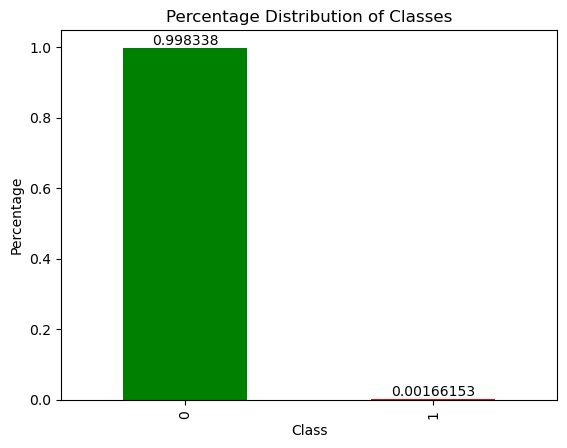

In [116]:
# Visulize the class distribution to show the imbalance
ax = data['Class'].value_counts(normalize = True).plot.bar(color = ['g', 'r'])
ax.bar_label(ax.containers[0], label_type='edge')
plt.title('Percentage Distribution of Classes')
plt.xlabel('Class')
plt.ylabel('Percentage')
plt.show()

In [117]:
# Distribution of classes with time
data_fraud = data[data['Class'] == 1]
data_non_fraud = data[data['Class'] == 0]

In [118]:
# validation 2 dataframes
print(data_fraud.shape)
print(data_non_fraud.shape)

(83, 31)
(49871, 31)


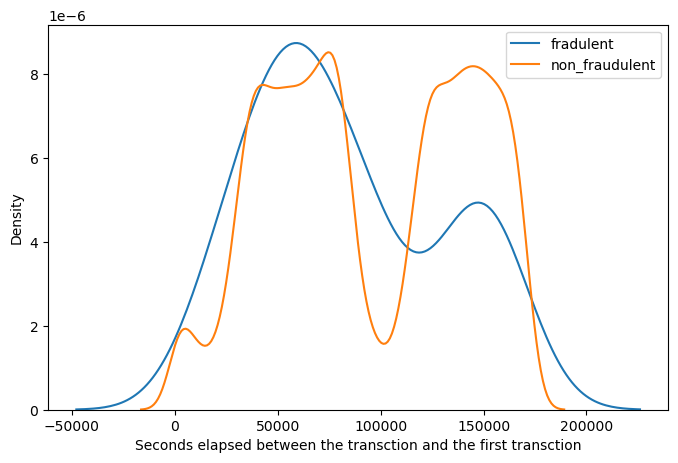

In [119]:
# distribution plot

plt.figure(figsize=(8, 5))
ax = sns.distplot(data_fraud['Time'], label='fradulent', hist=False)
ax = sns.distplot(data_non_fraud['Time'], label='non_fraudulent', hist=False)
ax.set(xlabel='Seconds elapsed between the transction and the first transction')
plt.legend(loc='best')
plt.show()

# Findings :
Can not find any specific pattern for the fraudulent and non-fraudulent transctions with respect to Time. Hence, we can drop the Time column.

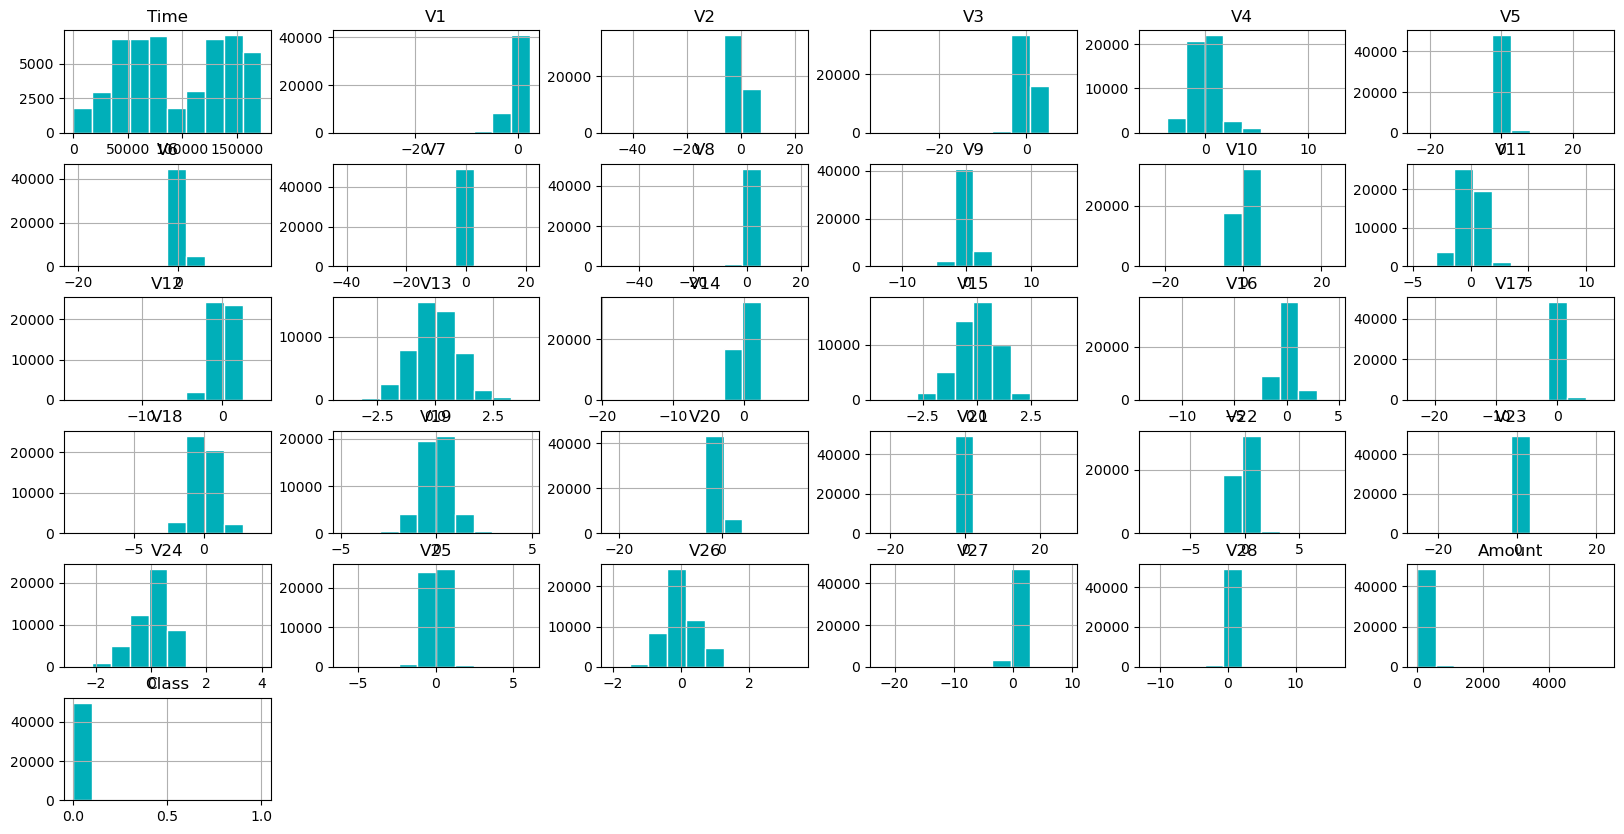

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,49954.000000,49954.000000,49954.000000,49954.000000,49954.000000,49954.000000,49954.000000,49954.000000,49954.000000,49954.000000,...,49954.000000,49954.000000,49954.000000,49954.000000,49954.000000,49954.000000,49954.000000,49954.000000,49954.000000,49954.000000
mean,94956.694559,-0.000994,-0.000850,0.001906,0.001803,0.002831,0.001529,-0.003174,0.000438,-0.003118,...,-0.001827,0.004315,0.000902,0.000427,0.003935,0.001181,0.002233,-0.001442,87.430244,0.001662
std,47485.947118,1.958721,1.631368,1.524284,1.414673,1.352115,1.316773,1.207458,1.210733,1.104893,...,0.736061,0.727124,0.591668,0.607587,0.518001,0.481557,0.404789,0.324446,224.028636,0.040728
min,0.000000,-34.148234,-48.060856,-33.680984,-5.560118,-23.669726,-20.869626,-41.506796,-50.420090,-13.434066,...,-22.889347,-8.887017,-25.356744,-2.824849,-6.035054,-2.068561,-22.565679,-11.710896,0.000000,0.000000
25%,54354.250000,-0.919527,-0.603411,-0.893537,-0.847125,-0.697698,-0.766760,-0.559197,-0.209853,-0.646422,...,-0.228004,-0.541968,-0.164283,-0.354839,-0.314121,-0.324971,-0.070199,-0.052975,5.672500,0.000000
50%,84872.500000,0.019522,0.063720,0.179493,-0.019872,-0.048553,-0.272947,0.035928,0.021593,-0.053737,...,-0.029415,0.011074,-0.013122,0.042428,0.023361,-0.051472,0.001321,0.010609,22.050000,0.000000
75%,139371.750000,1.318485,0.799064,1.034028,0.741945,0.618025,0.407070,0.571267,0.324293,0.592003,...,0.187385,0.533437,0.146441,0.438988,0.350821,0.241460,0.089820,0.077982,77.600000,0.000000
max,172787.000000,2.439207,21.467203,9.382558,12.699542,29.016124,16.493227,21.437514,19.168327,15.594995,...,27.202839,8.361985,22.083545,3.990646,6.070850,3.463246,9.200883,15.942151,5680.000000,1.000000


In [120]:
# Distribution 
numbers = data.select_dtypes(['int64', 'float64']).columns.to_list()
data.hist(figsize=(20,10), edgecolor='white', color='#00afb9')
plt.show()
display(data[numbers].describe())

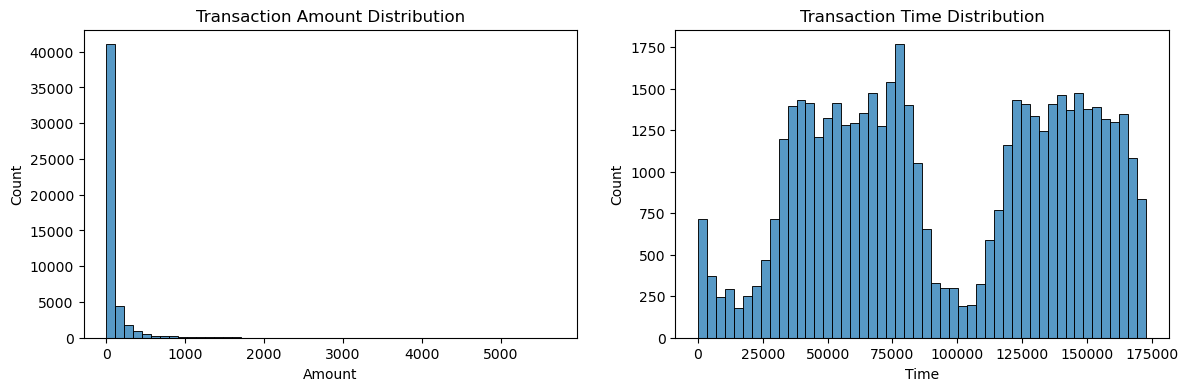

In [121]:
# Plot Amount and Time distributions
fig, ax = plt.subplots(1, 2, figsize=(14,4))
sns.histplot(data['Amount'], bins=50, ax=ax[0])
ax[0].set_title('Transaction Amount Distribution')
sns.histplot(data['Time'], bins=50, ax=ax[1])
ax[1].set_title('Transaction Time Distribution')
plt.show()

In [122]:
# dropping the Time column
data.drop('Time', axis=1, inplace=True)

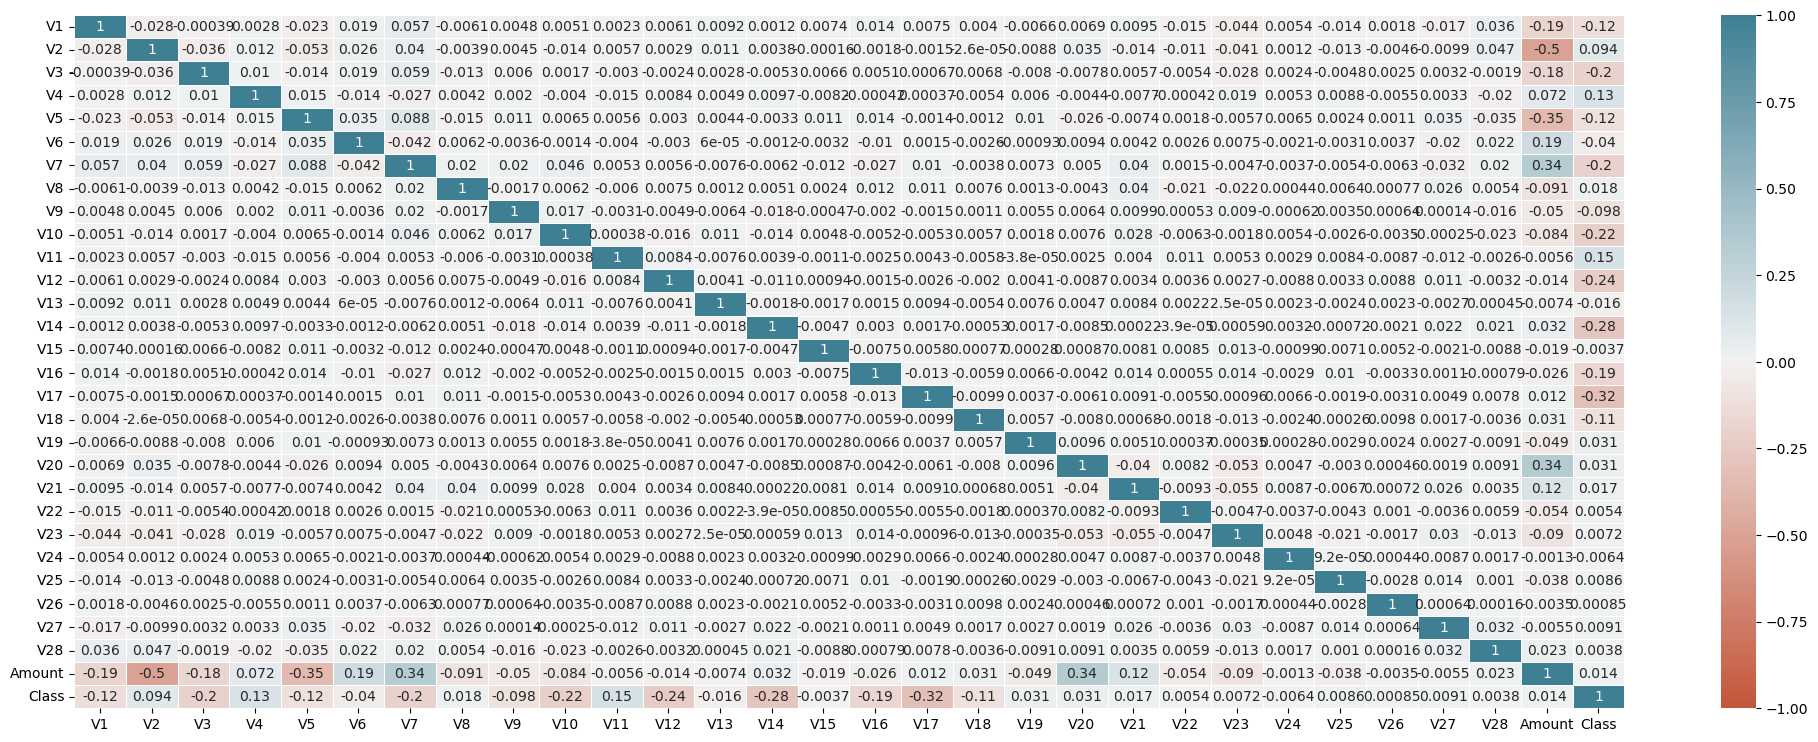

In [123]:
# Check correlation
fig, ax = plt.subplots(figsize=(25,9))
sns.heatmap(data[data.columns].corr(), vmin=-1, vmax=1, cmap=sns.diverging_palette(20, 220, as_cmap=True), annot=True, linewidths=.5)
plt.show()

In [124]:
data.shape

(49954, 30)

In [125]:
# Distribution of class with Amount
data[data.Class == 1].Amount.describe()

count      83.000000
mean      164.233855
std       311.803585
min         0.000000
25%         1.000000
50%         8.300000
75%       124.910000
max      1504.930000
Name: Amount, dtype: float64

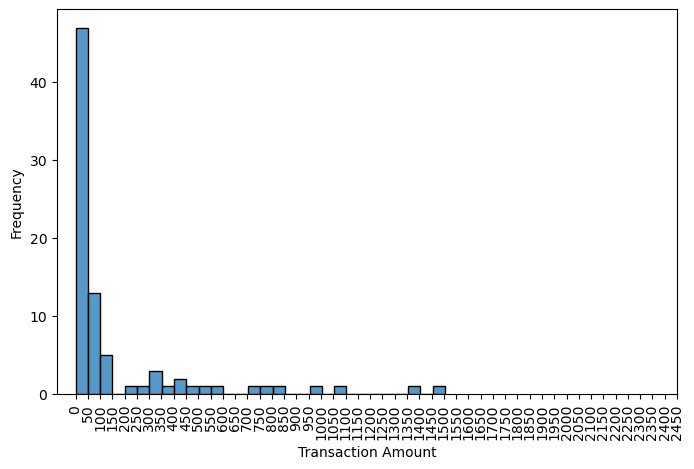

In [126]:
# distribution of Fradulent data
plt.figure(figsize=(8, 5))
sns.histplot(data_fraud['Amount'], binwidth=50)
plt.xlabel('Transaction Amount')
plt.ylabel('Frequency')
plt.xticks(range(0, 2500, 50), rotation=90)
plt.show()

Most of the fradulent transactions are in the range of 0-50 dollars. Highest Fraud transaction was at between 2100-2150 dollars

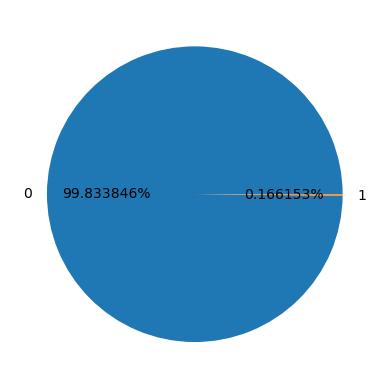

In [127]:
# Show the imbalanced data visually
outcome_counts = data["Class"].value_counts()
plt.pie(outcome_counts, labels = outcome_counts.index, autopct = "%f%%")
plt.show()

As we have seen that the data is heavily imbalanced, where only 0.16% transctions are fraudulent, which can affect when evaluating the model.


In [128]:
# Get all features in X without Class
X = data.drop(['Class'], axis=1)

In [129]:
# Get the target Class for prediction
y = data['Class']

In [130]:
# Validate both X and y

In [131]:
X.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
43428,-16.526507,8.584972,-18.649853,9.505594,-13.793819,-2.832404,-16.701694,7.517344,-8.507059,-14.110184,...,-1.514923,1.190739,-1.127670,-2.358579,0.673461,-1.413700,-0.462762,-2.018575,-1.042804,364.19
49906,0.339812,-2.743745,-0.134070,-1.385729,-1.451413,1.015887,-0.524379,0.224060,0.899746,-0.565012,...,0.506044,-0.213436,-0.942525,-0.526819,-1.156992,0.311211,-0.746647,0.040996,0.102038,520.12
29474,1.399590,-0.590701,0.168619,-1.029950,-0.539806,0.040444,-0.712567,0.002299,-0.971747,0.756801,...,0.212877,0.102398,0.168269,-0.166639,-0.810250,0.505083,-0.232340,0.011409,0.004634,31.00
276481,-0.432071,1.647895,-1.669361,-0.349504,0.785785,-0.630647,0.276990,0.586025,-0.484715,-1.376648,...,-0.244633,0.358932,0.873663,-0.178642,-0.017171,-0.207392,-0.157756,-0.237386,0.001934,1.50
278846,2.014160,-0.137394,-1.015839,0.327269,-0.182179,-0.956571,0.043241,-0.160746,0.363241,0.259452,...,-0.255293,-0.238644,-0.616400,0.347045,0.061561,-0.360196,0.174730,-0.078043,-0.070571,0.89


In [132]:
y.head()

43428     1
49906     0
29474     0
276481    0
278846    0
Name: Class, dtype: int64

## Two data balancing techniqes are applied and tested.

In [133]:
# 1. Balancing with SMOTE
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X, y)
print("\nAfter SMOTE balancing:")
print(pd.Series(y_smote).value_counts())


After SMOTE balancing:
Class
1    49871
0    49871
Name: count, dtype: int64


In [134]:
# 2. Alternative: Random UnderSampling (for future analysis)
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=42)
X_rus, y_rus = rus.fit_resample(X, y)
print("\nAfter Random UnderSampling:")
print(pd.Series(y_rus).value_counts())



After Random UnderSampling:
Class
0    83
1    83
Name: count, dtype: int64


In [135]:
# Scale the data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_smote_scaled = scaler.fit_transform(X_smote) # SMOTE
X_rus_scaled = scaler.fit_transform(X_rus) # RandomUnderSampler

# Training the data balanced through SMOTE

In [136]:
# Train and test the data using SMOTE data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_smote_scaled, y_smote, test_size=0.2, random_state=42, stratify=y_smote
)


In [137]:
# Importing libraries for cross validation
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

In [138]:
# Get the best parameter and score for all the models for traning
best_model, best_params, best_score = fit_best_models(X_train, y_train)


In [139]:
print("Models:", best_model)

Models: {'logreg': Pipeline(steps=[('scaler', StandardScaler()),
                ('clf', LogisticRegression(C=10))]), 'rf': Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 RandomForestClassifier(n_estimators=50, random_state=42))]), 'dt': Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 DecisionTreeClassifier(criterion='entropy', random_state=42))])}


In [140]:
print("Parameter:", best_params)

Parameter: {'logreg': {'clf__C': 10, 'clf__penalty': 'l2', 'clf__solver': 'lbfgs'}, 'rf': {'clf__max_depth': None, 'clf__min_samples_split': 2, 'clf__n_estimators': 50}, 'dt': {'clf__criterion': 'entropy', 'clf__max_depth': None, 'clf__min_samples_split': 2}}


In [141]:
print("Scores:", best_score)

Scores: {'logreg': 0.9680047256701261, 'rf': 0.9998746772939533, 'dt': 0.9989347507160554}


Based on the baseline model, RandomForestClassifier has performed the best.

In [142]:
# Using the best parameters from the previous step
# Predict if a transaction is fraud or not using the below 3 models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
#from sklearn.svm import SVC

models = {
    'Logistic Regression': LogisticRegression(penalty='l2', C=10, solver='lbfgs', random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, min_samples_split=2, random_state=42),
    'DecisionTree': DecisionTreeClassifier(criterion='entropy', min_samples_split=2, random_state=42)
}


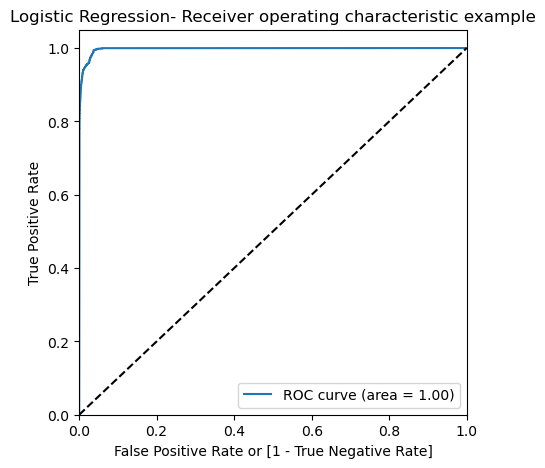

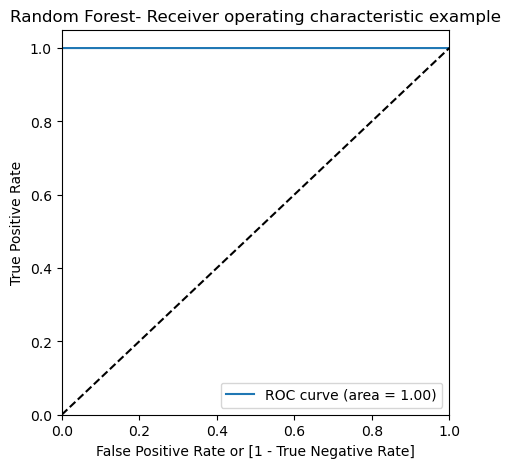

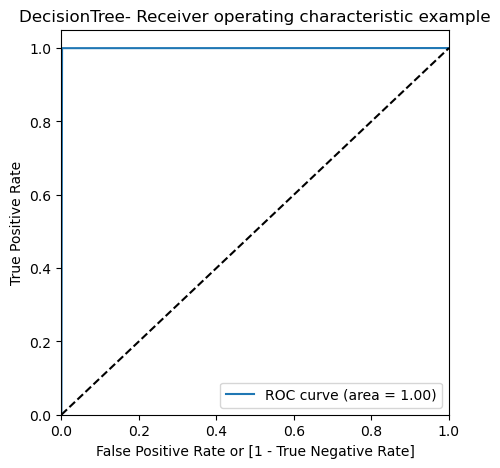

In [146]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

results = []
conf_matrices = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1] if hasattr(model, "predict_proba") else None
    
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba) if y_proba is not None else roc_auc_score(y_test, y_pred)
    
    results.append({
        'Model': name,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1 Score': f1,
        'ROC AUC': roc_auc
    })
    
    conf_matrices[name] = confusion_matrix(y_test, y_pred)
    draw_roc(name, y_test, y_proba)

In [148]:
# Compare the model accuracy by creating a dataframe for the model report
results_df = pd.DataFrame(results)
print("\nModel Comparison (SMOTE):")
print(results_df)


Model Comparison (SMOTE):
                 Model  Accuracy  Precision    Recall  F1 Score   ROC AUC
0  Logistic Regression  0.967617   0.976502  0.958292  0.967311  0.997549
1        Random Forest  0.999699   0.999399  1.000000  0.999699  0.999999
2         DecisionTree  0.998997   0.998298  0.999699  0.998998  0.998997


In [87]:
# Tune the model (Best model: Random Forest)
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}
rf = RandomForestClassifier(random_state=42)
grid = GridSearchCV(rf, param_grid, cv=3, scoring='f1', n_jobs=-1)
grid.fit(X_train, y_train)
print("\nBest Random Forest parameters:", grid.best_params_)
print("Best F1 Score from GridSearchCV:", grid.best_score_)



Best Random Forest parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
Best F1 Score from GridSearchCV: 0.9998496381916336


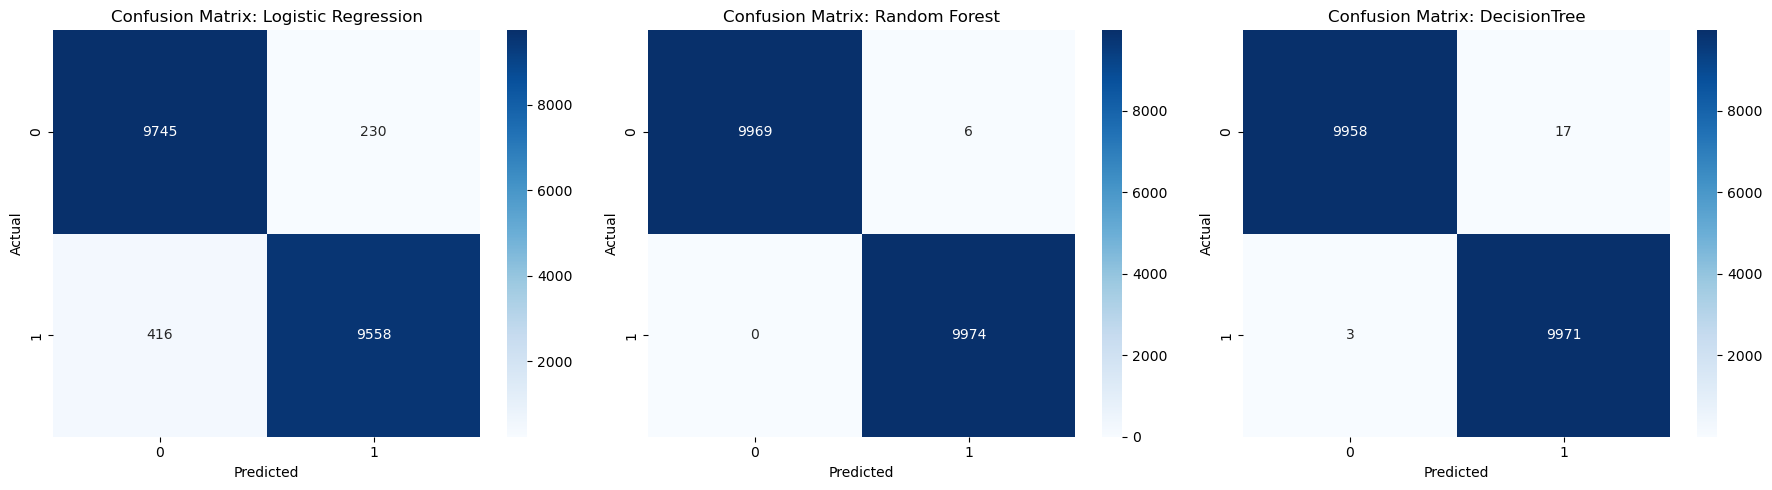

In [88]:

# Plot confusion matrices
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for ax, (name, cm) in zip(axes, conf_matrices.items()):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_title(f'Confusion Matrix: {name}')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
plt.tight_layout()
plt.show()

# Training the data balanced through RandomUnderSampler

In [89]:
# Try other balancing techniques for future analysis
# Repeat the same modeling steps with X_rus_scaled, y_rus

# Future analysis
X_train_rus, X_test_rus, y_train_rus, y_test_rus = train_test_split(X_rus_scaled, y_rus, test_size=0.2, random_state=42, stratify=y_rus)


In [90]:
# Get the best parameter and score for all the models for traning
best_model, best_params, best_score = fit_best_models(X_train_rus, y_train_rus)


In [91]:
print("Models:", best_model)

Models: {'logreg': Pipeline(steps=[('scaler', StandardScaler()),
                ('clf', LogisticRegression(C=10))]), 'rf': Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 RandomForestClassifier(n_estimators=200, random_state=42))]), 'dt': Pipeline(steps=[('scaler', StandardScaler()),
                ('clf', DecisionTreeClassifier(random_state=42))])}


In [92]:
print("Parameter:", best_params)

Parameter: {'logreg': {'clf__C': 10, 'clf__penalty': 'l2', 'clf__solver': 'lbfgs'}, 'rf': {'clf__max_depth': None, 'clf__min_samples_split': 2, 'clf__n_estimators': 200}, 'dt': {'clf__criterion': 'gini', 'clf__max_depth': None, 'clf__min_samples_split': 2}}


In [93]:
print("Scores:", best_score)

Scores: {'logreg': 0.9324786324786324, 'rf': 0.9549857549857549, 'dt': 0.9019943019943021}


In [94]:
# Use the best parameter from the above steps to train the model
models = {
    'Logistic Regression': LogisticRegression(penalty='l2', C=10, solver='lbfgs', random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=200, min_samples_split=2, random_state=42),
    'DecisionTree': DecisionTreeClassifier(criterion='gini', min_samples_split=2, random_state=42)
}

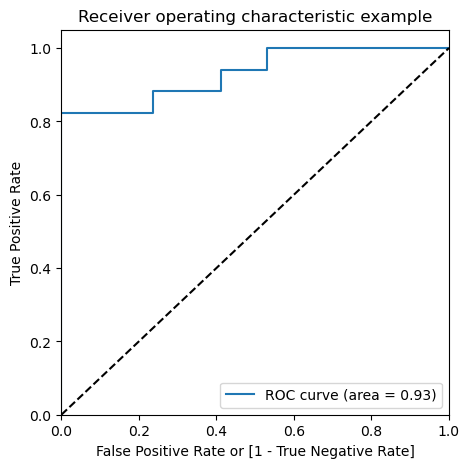

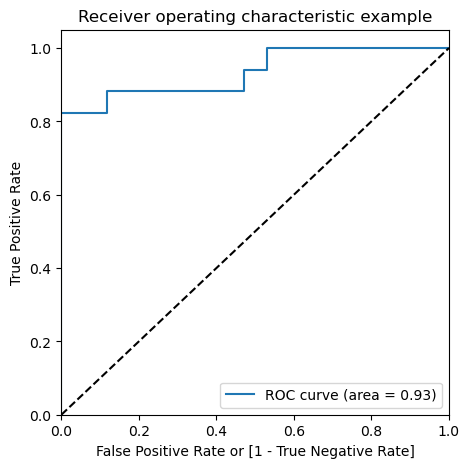

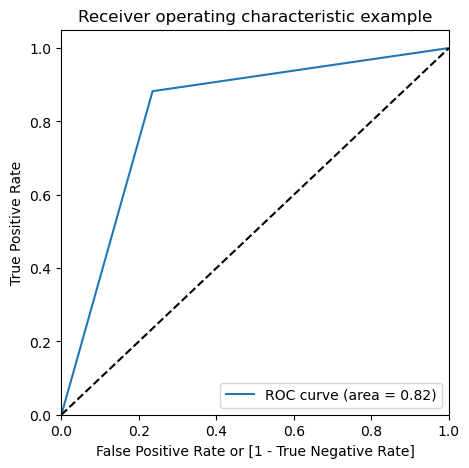

In [102]:
results = []
conf_matrices = {}

for name, model in models.items():
    model.fit(X_train_rus, y_train_rus)
    y_pred = model.predict(X_test_rus)
    y_proba = model.predict_proba(X_test_rus)[:,1] if hasattr(model, "predict_proba") else None
    
    acc = accuracy_score(y_test_rus, y_pred)
    prec = precision_score(y_test_rus, y_pred)
    rec = recall_score(y_test_rus, y_pred)
    f1 = f1_score(y_test_rus, y_pred)
    roc_auc = roc_auc_score(y_test_rus, y_proba) if y_proba is not None else roc_auc_score(y_test_rus, y_pred)
    
    results.append({
        'Model': name,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1 Score': f1,
        'ROC AUC': roc_auc
    })
    
    conf_matrices[name] = confusion_matrix(y_test_rus, y_pred)
    draw_roc(y_test_rus, y_proba)

In [97]:
# Compare the model accuracy by creating a dataframe for the model report
results_df = pd.DataFrame(results)
print("\nModel Comparison (RandomUnderSampler):")
print(results_df)


Model Comparison (RandomUnderSampler):
                 Model  Accuracy  Precision    Recall  F1 Score   ROC AUC
0  Logistic Regression  0.882353   0.933333  0.823529  0.875000  0.930796
1        Random Forest  0.911765   1.000000  0.823529  0.903226  0.934256
2         DecisionTree  0.823529   0.789474  0.882353  0.833333  0.823529


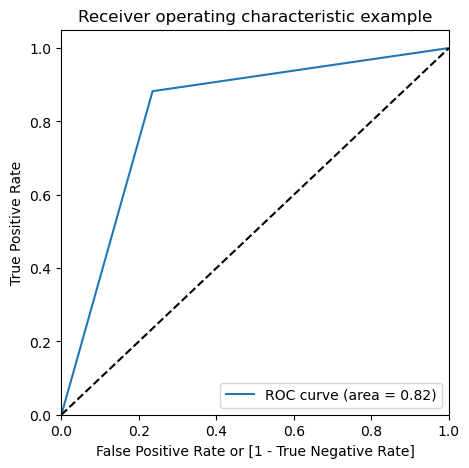

0.8235294117647058

In [101]:
# Plot the ROC curve
from sklearn import metrics
draw_roc(y_test_rus, y_proba)

In [98]:
# Tune the model (Random Forest)
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}
rf = RandomForestClassifier(random_state=42)
grid = GridSearchCV(rf, param_grid, cv=3, scoring='f1', n_jobs=-1)
grid.fit(X_train_rus, y_train_rus)
print("\nBest Random Forest parameters:", grid.best_params_)
print("Best F1 Score from GridSearchCV:", grid.best_score_)


Best Random Forest parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
Best F1 Score from GridSearchCV: 0.9512195121951219


Summary of Steps:
1. Read the data
2. EDA: Info, describe, class distribution, plots
3. Check imbalance: Print class counts
4. Balance data: SMOTE (over-sampling) and RandomUnderSampler (under-sampling)
5. Scale data: StandardScaler
6. Train/test split
7. Modeling: Logistic Regression, Random Forest, DecisionTree
8. Compare models: DataFrame with metrics
9. Tune model: GridSearchCV for Random Forest
10. Plot confusion matrices
11. Other balancing techniques: Code for under-sampling included


We can see that among all the models we tried (Logistic, Decision Tree, and Random Forest), almost all of them have performed well.
But if we were to choose one of them , we can go for the best as Random Forest with better accuracy and F1-score.

In [1]:
# Will try to add additional models if time allows

## Additional information will be delivered as part of the final deliverable.